# Finding Similar Songs on Spotify - Part 3 - Siamese Networks with Tag Similarity

In this tutorial I will demonstrate how to apply machine learning to search for similar songs on Spotify.

## Tutorial Overview

1. Loading data
2. Preprocess data
3. Define Model
4. Fit Model
5. Evaluate Model



## Requiremnts

Install the following dependencies to run this tutorial:

In [1]:
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "1"

import tensorflow as tf

/home/schindler/anaconda/python2/envs/py36/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [2]:
# visualization
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
matplotlib.style.use('ggplot')
from IPython.display import IFrame

# numeric and scientific processing
import numpy as np
import pandas as pd
from scipy.interpolate import RectBivariateSpline
from sklearn.preprocessing import LabelEncoder, MultiLabelBinarizer
from scipy.spatial.distance import dice, pdist, squareform

# misc
import os
import progressbar

# spotify API
import spotipy
import spotipy.util as util

# local caching
from joblib import Memory

# deep learning
from keras.models           import Model
from keras.layers           import Input, Lambda, Dense, Bidirectional
from keras.layers.recurrent import LSTM
from keras.layers.merge     import concatenate
from keras.optimizers       import Nadam
from keras import backend as K

# functions from Tutorial Part 1
import tutorial_functions as tut_func

Using TensorFlow backend.


# Loading Data

We will use the same data that we downloaded from Spotify in Part 1 of the Tutorial. Because we used the joblib library, we will not have to wait that long, because the data is already cached on our harddrive.

Update the following two variables according the credentials you received from Spotify

In [3]:
SPOTIFY_USER = ""

os.environ["SPOTIPY_CLIENT_ID"]     = ""
os.environ["SPOTIPY_CLIENT_SECRET"] = ""

The same playlists as used in Part 1:

In [4]:
playlists = [
    
     {"name": "clubbeats",    "uri": "spotify:user:spotify:playlist:37i9dQZF1DXbX3zSzB4MO0"},
     {"name": "softpop",      "uri": "spotify:user:spotify:playlist:37i9dQZF1DWTwnEm1IYyoj"},
     {"name": "electropop",   "uri": "spotify:user:spotify:playlist:37i9dQZF1DX4uPi2roRUwU"},
     {"name": "rockclassics", "uri": "spotify:user:spotify:playlist:37i9dQZF1DWXRqgorJj26U"},
     {"name": "rockhymns",    "uri": "spotify:user:spotify:playlist:37i9dQZF1DX4vth7idTQch"},
     {"name": "soft_rock",    "uri": "spotify:user:spotify:playlist:37i9dQZF1DX6xOPeSOGone"},
     {"name": "metalcore",    "uri": "spotify:user:spotify:playlist:37i9dQZF1DWXIcbzpLauPS"}, 
     {"name": "metal",        "uri": "spotify:user:spotify:playlist:37i9dQZF1DWWOaP4H0w5b0"},
     {"name": "classic_metal","uri": "spotify:user:spotify:playlist:37i9dQZF1DX2LTcinqsO68"},
     {"name": "grunge",       "uri": "spotify:user:spotify:playlist:37i9dQZF1DX11ghcIxjcjE"},
     {"name": "hiphop",       "uri": "spotify:user:spotify:playlist:37i9dQZF1DWVdgXTbYm2r0"},
     {"name": "poppunk",      "uri": "spotify:user:spotify:playlist:37i9dQZF1DXa9wYJr1oMFq"},
     {"name": "classic",      "uri": "spotify:user:spotify:playlist:37i9dQZF1DXcN1fAVSf7CR"}
    
]

Connect to the Spotify API

In [5]:
token = util.prompt_for_user_token(SPOTIFY_USER, 
                                   "playlist-modify-public", 
                                   redirect_uri="http://localhost/")

sp = spotipy.Spotify(auth=token)

Define the local chache directory. This should be the same as in Part 1 of the tutorial.

In [6]:
memory = Memory(cachedir='/home/schindler/tmp/spotify/', verbose=0)

In [7]:
@memory.cache
def get_spotify_data(track_id):
    
    # meta-data
    track_metadata      = sp.track(track_id)
    album_metadata      = sp.album(track_metadata["album"]["id"])
    artist_metadata     = sp.artist(track_metadata["artists"][0]["id"])
    
    # feature-data
    sequential_features = sp.audio_analysis(track_id)
    trackbased_features = sp.audio_features([track_id])
    
    return track_metadata, album_metadata, artist_metadata, sequential_features, trackbased_features

Start loading the Spotify Data

In [8]:
# Get Playlist meta-data
playlists = tut_func.get_playlist_metadata(sp, playlists)

# Get track-ids of all playlist entries
playlists = tut_func.get_track_ids(sp, playlists)

num_tracks_total = np.sum([playlist["num_tracks"] for playlist in playlists])

# Fetch data and features from Spotify
pbar = progressbar.ProgressBar(max_value=num_tracks_total)
pbar.start()

raw_track_data      = []
processed_track_ids = []

for playlist in playlists:

    for track_id in playlist["track_ids"]:

        try:
            # avoid duplicates in the data-set
            if track_id not in processed_track_ids:

                # retrieve data from Spotify
                spotify_data = get_spotify_data(track_id)

                raw_track_data.append([playlist["name"], spotify_data])
                processed_track_ids.append(track_id)

        except Exception as e:
            print(e)

        pbar.update(len(raw_track_data))

 98% (1059 of 1078) |#################### | Elapsed Time: 0:02:11 ETA:  0:00:03

### Aggregate feature-data

Currently we only have a list of raw data-objects retrieved from the Spotify API. We need to transform this information to a more structured format.

In [9]:
# Aggregate Meta-data
metadata = tut_func.aggregate_metadata(raw_track_data)

# Aggregate Feature-data
feature_data = tut_func.aggregate_featuredata(raw_track_data, metadata)

# standardize sequential_features
feature_data -= feature_data.mean(axis=0)
feature_data /= feature_data.std(axis=0)

# Tag Similarities

Tag similarity refers to the semantic relationship between two labels. In the context of this tutorial we are talking about genre labels. These are provided by the Spotify API for each artist. This is not as precise as for each track, but we take what we get. We still need to consider that an artist might change its artistic orientation which means he can cross or change its genre or on the other hand, the genre can change itself (e.g. Rhythm and Blues). Most of all, we should keep in mind that the concept of music genre is highly subjective and its interpretation might vary between the annotators who labelled the provided tracks.

So this is how the labels look like:

In [10]:
print("Track : " + " - ".join(metadata[["artist_name", "title"]].loc[330]) )
print("Labels: '" + "', '".join(metadata.loc[330].genres) + "'")

Track : Guns N' Roses - Sweet Child O' Mine
Labels: 'album rock', 'classic rock', 'glam metal', 'hard rock', 'rock'


### Calculating similarities between Tracks based on labels

To estimate the similarities between tracks, we first have to assess, how many labels  we have and how they are distributed. First we convert the string labels into a binary matrix:

In [11]:
mlb = MultiLabelBinarizer()
mlb = mlb.fit(metadata.genres)

genres_bin = pd.DataFrame(mlb.transform(metadata.genres), columns=mlb.classes_)

Now we remove all tracks for which no labels were provided:

In [12]:
# filter tracks without genre tags
genres_bin = genres_bin[genres_bin.sum(axis=1) > 0]

Now we align the metadata and the feature-data to the filtered metadata:

In [13]:
# copy the metadata
metadata_aligned = metadata

# create an additional column as an index into the feature-data
metadata_aligned["featurespace_index"] = metadata.index.values

# reduce the aligned metadata to those tracks with provided genre labels
metadata_aligned = metadata_aligned.iloc[genres_bin.index]

# reset the index
metadata_aligned = metadata_aligned.reset_index()

### Term (Label) Frequencies

As a next step we will analyze how many labels we have in our dataset, which ones are the most frequently used and so on.

So let's see what are the most used genre labels in our dataset:

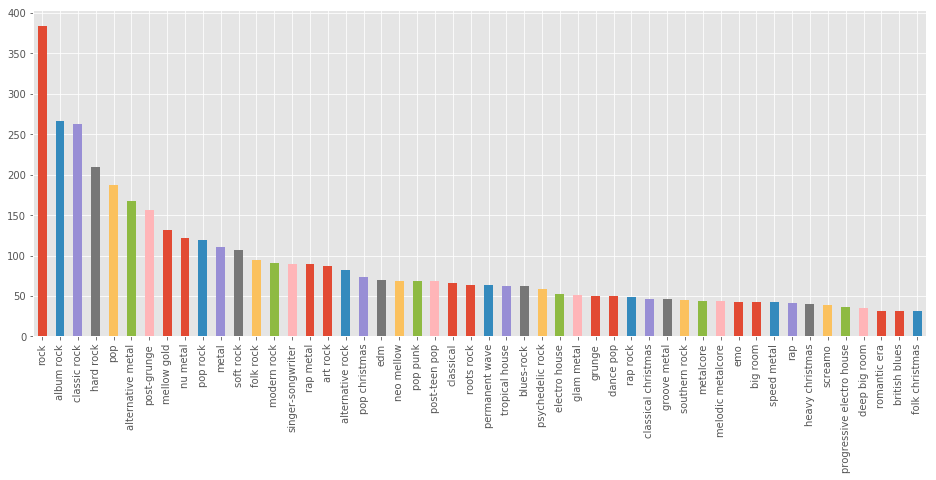

In [14]:
genres_bin.sum(axis=0).sort_values(ascending=False)[:50].plot(kind="bar", figsize=(16,6));

As we can see, the "rock" genre is the most dominating one. Thus, providing this label to a track does not add more relevant information to it to distinguish it from other tracks. The term "romantic" on the other hand is less frequent which makes it more discrimitative.

In [15]:
tf            = genres_bin.sum(axis=0)
idf           = np.log(genres_bin.shape[0] / tf)
genres_tf_idf = genres_bin / idf

Based on this rescaled label weights, we can calculate the tag-based similarties between all pairs of tracks. We will use the Dice metric

In [16]:
# the pdist function calculates all pairwise distances
dists = pdist(genres_tf_idf, 'dice')

# pdist returns a list of results. We use the squareform function to convert this into a symmetric matrix
tag_based_track_similarities = pd.DataFrame((1 - squareform(dists)), 
                                            index   = genres_tf_idf.index,
                                            columns = genres_tf_idf.index)

Now we can use this to search for similar tracks using the tag-similarities:

In [17]:
query_track_idx = 33

print(metadata_aligned.iloc[query_track_idx])

# get the similar tracks from the distance-matrix
similar_tracks_idx = tag_based_track_similarities[query_track_idx].sort_values(ascending=False).index

# filter the aligned metadata
result        = metadata_aligned.loc[similar_tracks_idx]
result["sim"] = tag_based_track_similarities.loc[query_track_idx,
                                                 similar_tracks_idx].values

# show results
display_cols = ["artist_name", "title", "album_name", "year", "genres", "playlist", "sim"]
result[display_cols][:10]

index                                     44
track_id              41Y5sPsWLArrksKhXheQ8f
artist_name                    Damien N-Drix
title                                 Inkali
album_name                            Inkali
label                       Spinnin' Records
duration                              218890
popularity                                51
year                                    2017
genres                       [electro house]
playlist                           clubbeats
featurespace_index                        44
Name: 33, dtype: object


/home/schindler/anaconda/python2/envs/py36/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
  if __name__ == '__main__':


,artist_name,title,album_name,year,genres,playlist,sim
33,Damien N-Drix,Inkali,Inkali,2017,[electro house],clubbeats,1.000000
4,Don Diablo,Momentum,Momentum,2017,"[big room, deep big room, edm, electro house, ...",clubbeats,0.933333
52,SNBRN,Lovin' Me,Lovin' Me,2018,"[deep tropical house, edm, electro house, hous...",clubbeats,0.933333
23,KSHMR,Kolkata,Kolkata,2017,"[big room, deep big room, edm, electro house, ...",clubbeats,0.933333
38,Henry Fong,Bubblin Anthem,Bubblin Anthem,2017,"[big room, deep big room, edm, electro house, ...",clubbeats,0.923077
295,AC/DC,Dirty Deeds Done Dirt Cheap,Dirty Deeds Done Dirt Cheap,1976,"[album rock, classic rock, hard rock, heavy ch...",rockclassics,0.875000
36,Marco V,Chills,Chills,2018,"[bubble trance, progressive house, progressive...",clubbeats,0.875000
6,Timmy Trumpet,Punjabi,Punjabi,2017,"[australian dance, catstep, edm, melbourne bou...",clubbeats,0.875000
16,TS7,Real Raver,Real Raver,2018,"[bassline, deep groove house, house, speed gar...",clubbeats,0.875000
40,TJR,Time To Jack,Time To Jack,2017,"[big room, deep big room, edm, electro house, ...",clubbeats,0.875000


# Interposed Question

*The tag-similarities seem to be quite accurate. Why don't we use them instead of this complicated and computing intensive Neural Networks which train on audio data?*

Well, this seems obvious on the first hand, but remember that we don't have labels for all artists. Thus, for those without labels, we cannot calculate similarities. But, we have audio features for all tracks. Thus, we use the subset of provided labels to train a general model based on audio content.

# Train the Siamese Networks on the Tag-Similarity Ground-Truth

We use the same Siamese Network architecture presented in part 2 of this tutorial. Also the method to create the pairwise training-data is the same. Please refer to part 2 for further details.

In [18]:
def create_siamese_network(input_dim):

    # input layers
    input_left  = Input(shape=input_dim)
    input_right = Input(shape=input_dim)

    # shared fully connected layers
    shared_fc_1 = Dense(100, activation="selu")
    shared_fc_2 = Dense(100, activation="selu")    
    
    # siamese layers
    left_twin  = shared_fc_1(shared_fc_2(input_left))
    right_twin = shared_fc_1(shared_fc_2(input_right))

    # calc difference
    distance = Lambda(tut_func.euclidean_distance,
                      output_shape=lambda x: x[0])([left_twin, right_twin])

    return Model([input_left, input_right], distance)

### Create Data-Pairs

Now we have to prepare and partition the input data. We use the approach which considers identity. Thus, we will reduce the similarity values which have been looked-up from the distance-matrix by 0.1:

In [19]:
def create_pairs_with_sims_and_identity(feature_data, metadata, num_pairs_per_track, sims):
    
    data_pairs = []
    labels     = []
    
    for row_id, q_track in metadata.sample(frac=1).iterrows():
        
        # identical pair
        data_pairs.append([feature_data[[row_id]][0], feature_data[[row_id]][0]])
        labels.append(1)
                
        for _ in range(num_pairs_per_track):
            
            # search similar and dissimilar examples
            pos_example = metadata[metadata.playlist == q_track.playlist].sample(1)
            neg_example = metadata[metadata.playlist != q_track.playlist].sample(1)

            # create feature pairs
            
            # similar pair
            data_pairs.append([feature_data[[metadata.loc[row_id].featurespace_index]][0], feature_data[[pos_example.featurespace_index]][0]])
            sim_val = sims.iloc[row_id, pos_example.index].values[0] - 0.1
            labels.append(np.max([0, sim_val]))
            
            # dissimilar pair
            data_pairs.append([feature_data[[metadata.loc[row_id].featurespace_index]][0], feature_data[[neg_example.featurespace_index]][0]])
            sim_val = sims.iloc[row_id, neg_example.index].values[0] - 0.1
            labels.append(np.max([0, sim_val]))
            

    return np.array(data_pairs), np.array(labels)

Execute the function to prepare the data:

In [20]:
data_pairs, labels = create_pairs_with_sims_and_identity(feature_data, 
                                                         metadata_aligned, 
                                                         10, 
                                                         tag_based_track_similarities)

data_pairs.shape

(20307, 2, 69)

Prepare the Siamese Neural Network

In [21]:
# define the model
model = create_siamese_network(data_pairs[:,0].shape[1:])

# define the optimizer
opt = Nadam(lr=0.001)

# compile the model
model.compile(loss      = tut_func.contrastive_loss, 
              optimizer = opt)

Train the network on the tag-similarity ground-truth

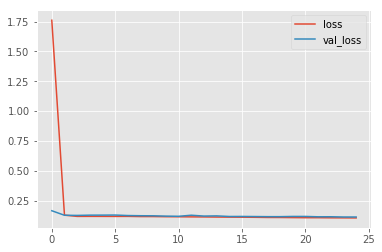

In [22]:
model.fit([data_pairs[:, 0], data_pairs[:, 1]], 
                labels, 
                batch_size       = 24, 
                verbose          = 0, 
                epochs           = 25, 
                callbacks        = [tut_func.PlotLosses()], 
                validation_split = 0.1);

### Evaluate by Example

The following function calculated the distances between a given query track and all other tracks of the collection. The result is a list of distances where the smallest distance coresponds with the most similar track. The list is sorted descendingly and the top-ten similar tracks are presented below the information of the query track. The Spotify playlist we created at the beginning will also be updated with the query results. Thus, you can listen to it in your Spotify client.

In [23]:
def similar(model, query_idx):
    
    print(metadata.iloc[query_idx])
    
    # calclulate predicted distances between query track and all others
    res = [model.predict([feature_data[[query_idx]], feature_data[[i]]]) for i in range(feature_data.shape[0])]

    # reshape
    res = np.array(res)
    res = res.reshape(res.shape[0])

    # get sorted indexes in ascending order (smallest distance to query track first)
    si = np.argsort(res)
    
    # output filter
    display_cols = ["artist_name", "title", "album_name", "year","playlist"]
    
    return metadata.loc[si, display_cols][:10]

Now let's check the results for some individual tracks by supplying the index to our dataset:

In [24]:
similar(model, 33)

track_id                                         637McrDyDQ9CffkFuZGRpq
artist_name                                                       KSHMR
title                                                           Kolkata
album_name                                                      Kolkata
label                                                            Dharma
duration                                                         206250
popularity                                                           54
year                                                               2017
genres                [big room, deep big room, edm, electro house, ...
playlist                                                      clubbeats
featurespace_index                                                   33
Name: 33, dtype: object


,artist_name,title,album_name,year,playlist
33,KSHMR,Kolkata,Kolkata,2017,clubbeats
16,Hardwell,Get Low,Get Low,2018,clubbeats
34,Garmiani,Fogo,Fogo,2017,clubbeats
79,Sander van Doorn,Riff - SvD x David Tort Remix,Riff (SvD x David Tort Remix),2017,clubbeats
6,Don Diablo,Momentum,Momentum,2017,clubbeats
70,Stadiumx,Spacebird,Spacebird,2017,clubbeats
49,Calvin Logue,Warrior,Warrior EP,2018,clubbeats
41,Tom & Jame,In The Air,In The Air,2017,clubbeats
38,Ummet Ozcan,Krypton,Krypton,2018,clubbeats
36,Hardwell,Safari,Safari,2018,clubbeats


# Using LSTMs to train on Sequential Data

This is again identical to part 2. We just use the improved ground-truth data which we have created from the genre tags using tag-similarity metrics.

In [25]:
def aggregate_features_sequential(seq_data, track_data, len_segment_frames, len_segment_sec, m_data, with_year=False, with_popularity=False):
    
    # sequential data
    segments = seq_data["segments"]
    sl       = len(segments)
    
    mfcc              = np.array([s["timbre"]            for s in segments])
    chroma            = np.array([s["pitches"]           for s in segments])
    loudness_max      = np.array([s["loudness_max"]      for s in segments]).reshape((sl,1))
    loudness_start    = np.array([s["loudness_start"]    for s in segments]).reshape((sl,1))
    loudness_max_time = np.array([s["loudness_max_time"] for s in segments]).reshape((sl,1))
    duration          = np.array([s["duration"]          for s in segments]).reshape((sl,1))
    confidence        = np.array([s["confidence"]        for s in segments]).reshape((sl,1))
        
    # concatenate sequential features
    sequential_features = np.concatenate([mfcc, chroma, loudness_max, loudness_start, 
                                          loudness_max_time, duration, confidence], axis=1)

    # calculate length of segment (in ms)
    length_of_track        = track_data[0]["duration_ms"] / 1000.
    length_of_segment      = length_of_track / len(segments)
    num_segments_for_n_sek = int(np.round(len_segment_sec / length_of_segment))
    
    # select a random lstm-input-segment from the aggregated feature data
    offset  = np.random.randint(0, sl - num_segments_for_n_sek)
    segment = sequential_features[offset:(offset+num_segments_for_n_sek),:]
    
    # re-scale segment length to desired length (in seconds)
    x  = np.arange(segment.shape[0])
    y  = np.arange(segment.shape[1])
    xx = np.linspace(x.min(),x.max(),len_segment_frames)

    newKernel = RectBivariateSpline(x,y,segment, kx=2,ky=2)
    segment   = newKernel(xx,y)
        
    # track-based data
    track_features = [track_data[0]["acousticness"],     # acoustic or not?
                      track_data[0]["danceability"],     # danceable?
                      track_data[0]["energy"],           # energetic or calm?
                      track_data[0]["instrumentalness"], # is somebody singing?
                      track_data[0]["liveness"],         # live or studio?
                      track_data[0]["speechiness"],      # rap or singing?
                      track_data[0]["tempo"],            # slow or fast?
                      track_data[0]["time_signature"],   # 3/4, 4/4, 6/8, etc.
                      track_data[0]["valence"]]          # happy or sad?
    
    if with_year:
        track_features.append(int(m_data["year"]))
        
    if with_popularity:
        track_features.append(int(m_data["popularity"]))
        
    
    return segment, track_features


Now lets prepare the input features. We will be using the following parameters

In [26]:
# number of input-vectors for the LSTM
len_segment_frames = 24

# number of seconds these vectors describe
len_segment_sec    = 6.

execute the function to prepare the data:

In [27]:
sequential_features = []
trackbased_features = []

for i, (_, spotify_data) in enumerate(raw_track_data):
    
    _, _, _, f_sequential, f_trackbased = spotify_data
    
    seq_feat, track_feat = aggregate_features_sequential(f_sequential, 
                                                         f_trackbased, 
                                                         len_segment_frames,
                                                         len_segment_sec,
                                                         metadata.loc[i],
                                                         with_year=True,
                                                         with_popularity=True)
    
    sequential_features.append(seq_feat)
    trackbased_features.append(track_feat)
    
sequential_features = np.asarray(sequential_features)
trackbased_features = np.asarray(trackbased_features)

print("sequential_features.shape:", sequential_features.shape)
print("trackbased_features.shape:", trackbased_features.shape)

sequential_features.shape: (1060, 24, 29)
trackbased_features.shape: (1060, 11)


### Normalization

As in the examples before, we need to normalize the data before using it with the neural networks

In [28]:
# standardize sequential_features
rows, x, y = sequential_features.shape
sequential_features  = sequential_features.reshape(rows, (x * y))
sequential_features -= sequential_features.mean(axis=0)
sequential_features /= sequential_features.std(axis=0)
sequential_features  = sequential_features.reshape(rows, x, y)

# standardize trackbased_features
trackbased_features -= trackbased_features.mean(axis=0)
trackbased_features /= trackbased_features.std(axis=0)

### Create Data-Pairs

Also like before, we have to prepare the paired training examples. We continue with the last approach presented in this part, which is based on the mutual similarities and includes identities. Each pair contains the sequential and track-based inputs.

In [29]:
def create_pairs_with_sims_and_identity_segments(sequential_features, trackbased_features, metadata, num_pairs_per_track, sims):
    
    data_pairs_seq   = []
    data_pairs_track = []
    labels           = []
    
    for row_id, q_track in metadata.sample(frac=1).iterrows():
        
        query_segment      = sequential_features[[metadata.loc[row_id].featurespace_index]][0]
        query_track_vector = trackbased_features[[metadata.loc[row_id].featurespace_index]][0]
        
        data_pairs_seq.append([query_segment, query_segment])
        data_pairs_track.append([query_track_vector, query_track_vector])
        labels.append(1)
        
        for _ in range(num_pairs_per_track):
            
            # search similar and dissimilar examples
            pos_example = metadata[metadata.playlist == q_track.playlist].sample(1)
            neg_example = metadata[metadata.playlist != q_track.playlist].sample(1)

            # create feature pairs
            data_pairs_seq.append([query_segment, sequential_features[[pos_example.featurespace_index]][0]])
            data_pairs_track.append([query_track_vector, trackbased_features[[pos_example.featurespace_index]][0]])
            labels.append(np.max([0, sims.iloc[row_id, pos_example.index].values[0] - 0.1]))

            data_pairs_seq.append([query_segment, sequential_features[[neg_example.featurespace_index]][0]])
            data_pairs_track.append([query_track_vector, trackbased_features[[neg_example.featurespace_index]][0]])
            labels.append(np.max([0, sims.iloc[row_id, neg_example.index].values[0] - 0.1]))

    return np.array(data_pairs_seq), np.array(data_pairs_track), np.asarray(labels)

Execute the function to prepare the results:

In [30]:
data_pairs_seq, data_pairs_track, labels = create_pairs_with_sims_and_identity_segments(sequential_features,
                                                                                        trackbased_features,
                                                                                        metadata_aligned, 
                                                                                        10,
                                                                                        tag_based_track_similarities)

### The Siamese Network Architecture using LSTMs

The network architecture consists again of shared "twin" layers. But, now two layers are shared. First the fully connected layers which train on the track-based features. Second, a bi-directional LSTM which trains on the re-scaled sequential data provided by the Spotify API. The network thus now takes four inputs. The outputs of the fully connected layer and the LSTM are finally joined and the Eucledian distance of each twin is calculated which is the final output of the model.

In [31]:
def create_siamese_network_with_lstm(data_pairs_seq, data_pairs_track):

    # sequential input
    input_seq_left  = Input(shape=data_pairs_seq[:, 0].shape[1:])
    input_seq_right = Input(shape=data_pairs_seq[:, 0].shape[1:])

    # track-based input
    input_track_left  = Input(shape=data_pairs_track[:, 0].shape[1:])
    input_track_right = Input(shape=data_pairs_track[:, 0].shape[1:])

    # shared bi-directional LSTM layer for the sequential features
    bdlstm = Bidirectional(LSTM(29, return_sequences=False, activation="selu"))

    # shared fully connected layers for the track-based features
    shared_fc_1 = Dense(11, activation="selu")
    shared_fc_2 = Dense(11, activation="selu")   

    # left twin
    seq_resp_left   = bdlstm(input_seq_left)
    track_resp_left = shared_fc_1(shared_fc_2(input_track_left))
    left_twin       = concatenate([seq_resp_left, track_resp_left], axis=1)

    # right twin
    seq_resp_right   = bdlstm(input_seq_right)
    track_resp_right = shared_fc_1(shared_fc_2(input_track_right))
    right_twin       = concatenate([seq_resp_right, track_resp_right], axis=1)

    # calc difference
    distance = Lambda(tut_func.euclidean_distance,
                      output_shape=lambda x: x[0])([left_twin, right_twin])

    return Model([input_seq_left, input_seq_right, input_track_left, input_track_right], distance)

Prepare the model:

In [32]:
# define the model
model_rnn = create_siamese_network_with_lstm(data_pairs_seq, data_pairs_track)

# define the optimizer
opt = Nadam(lr=0.001)

# compile the model
model_rnn.compile(loss      = tut_func.contrastive_loss, 
                  optimizer = opt)

Train the model

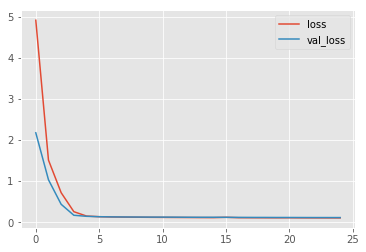

In [33]:
model_rnn.fit([data_pairs_seq[:, 0],  data_pairs_seq[:, 1], 
               data_pairs_track[:,0], data_pairs_track[:,1]], 
              labels, 
              batch_size       = 24, 
              verbose          = 0, 
              epochs           = 25,
              callbacks        = [tut_func.PlotLosses()], 
              validation_split = 0.1);

### Evaluate by Example

Due to the changed input, we also have to adapt the evaluation function to display example result-lists:

In [ ]:
def similar_rnn(model, query_idx):
    
    print(metadata.iloc[query_idx])
    
    # calclulate predicted distances between query track and all others
    res = [model.predict([sequential_features[[query_idx]], sequential_features[[i]], 
                          trackbased_features[[query_idx]], trackbased_features[[i]]]) \
           for i in range(feature_data.shape[0])]

    # reshape
    res = np.array(res)
    res = res.reshape(res.shape[0])

    # get sorted indexes in ascending order (smallest distance to query track first)
    si = np.argsort(res)
    
    # output filter
    display_cols = ["artist_name", "title", "album_name", "year","playlist"]
    
    return metadata.loc[si, display_cols][:10]

Now let's check the results for some individual tracks by supplying the index to our dataset:

In [ ]:
similar_rnn(model_rnn, 33)

track_id                                         637McrDyDQ9CffkFuZGRpq
artist_name                                                       KSHMR
title                                                           Kolkata
album_name                                                      Kolkata
label                                                            Dharma
duration                                                         206250
popularity                                                           54
year                                                               2017
genres                [big room, deep big room, edm, electro house, ...
playlist                                                      clubbeats
featurespace_index                                                   33
Name: 33, dtype: object
